In [23]:
import pandas as pd
import numpy as np


df = pd.read_csv("test.csv")

df.head()

,username,movie#1,movie#2,movie#3,movie#4,movie#5
0,id#0,83,42,37,13,78
1,id#1,87,21,69,24,34
2,id#2,97,88,0,74,67
3,id#3,90,43,32,0,75
4,id#4,79,53,43,94,67


In [24]:
#clean data
df.replace(np.NaN, 0, inplace=True)
df.head()

,username,movie#1,movie#2,movie#3,movie#4,movie#5
0,id#0,83,42,37,13,78
1,id#1,87,21,69,24,34
2,id#2,97,88,0,74,67
3,id#3,90,43,32,0,75
4,id#4,79,53,43,94,67


In [25]:
def get_neig(df: pd.DataFrame, i: int, k: int) -> pd.DataFrame:
    scores_table = df[df.columns[1:]]
    row = scores_table.iloc[i]
    distances = np.linalg.norm(scores_table -row, axis=1)
    #remove the user from user neighbors
    nearest_neighbor_ids = distances.argsort()[1:k+1]
    nearest_neighbors = scores_table.iloc[nearest_neighbor_ids]
    return nearest_neighbors  # type: ignore

get_neig(df, 0, 3)

,movie#1,movie#2,movie#3,movie#4,movie#5
3,90,43,32,0,75
71,83,35,38,30,65
53,75,41,46,34,87


In [26]:
import math
from scipy import stats
#helper funcs

def get_scores(df, i):
    return df.iloc[[i]][df.columns[1:]].values[0]

#my implementation
def get_wij(row_i, row_j):
    average_i = np.average(row_i)
    average_j = np.average(row_j)

    top_a = row_i - average_i
    top_b = row_j - average_j

    top_array = top_a * top_b
    top_value = np.sum(top_array)

    bottom_a_squared = top_a ** 2
    bottom_b_sum = np.sum(bottom_a_squared)
    bottom_a_root = np.sqrt(bottom_b_sum)

    bottom_b_squared = top_b ** 2
    bottom_b_sum = np.sum(bottom_b_squared)
    bottom_b_root = np.sqrt(bottom_b_sum)

    bottom_value = bottom_a_root * bottom_b_root

    return top_value/bottom_value

#library implementation
def get_wij_np(row_i, row_j):
    return np.corrcoef([row_i, row_j])[1, 0]



def get_rating(df: pd.DataFrame, i: int, a:int, k: int = 8):
    person_scores = get_scores(df, i)
    person_average = np.average(person_scores)

    top = 0
    bottom = 0

    neighbors_scores = get_neig(df, i, k)

    for index, scores in neighbors_scores.iterrows():
        correlation_pearson_score = get_wij(person_scores, scores)
        top += (scores[a] - np.average(scores)) * correlation_pearson_score
        bottom += abs(correlation_pearson_score)


    rating = person_average + (top/bottom)
    return rating

get_rating(df, 0, 1)

47.625488930214345

In [27]:
RATING_POINT = 75

def should_watch(df: pd.DataFrame, i: int, a: int, k: int = 8):
    rating = get_rating(df, i, a, k)
    return rating >= RATING_POINT

should_watch(df, 0, 1)

False

matches: 933, not matches: 67, error rate: 6.7


<BarContainer object of 2 artists>

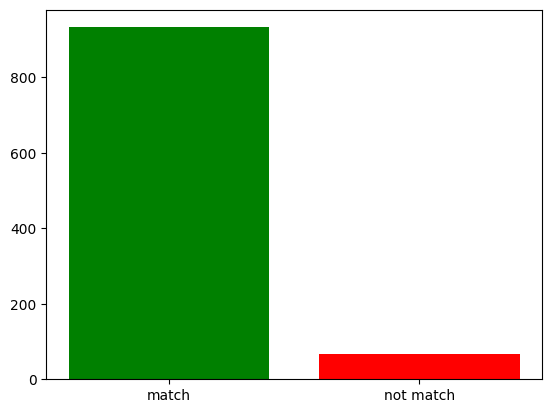

In [28]:
import matplotlib.pyplot as plt

def test_should_watch_diff(df: pd.DataFrame):
    diff_arr = []
    for row_idx in range(len(df)):
        scores = get_scores(df, row_idx)
        for score_idx, score in enumerate(scores):
            calc_should_watch = should_watch(df, row_idx, score_idx)
            real_should_watch = score >= RATING_POINT
            diff_arr.append(calc_should_watch == real_should_watch)
    
    return diff_arr

def percentage(part, whole):
  return 100 * float(part)/float(whole)

watch_diff = test_should_watch_diff(df)
matches = list(filter(lambda x: x == True, watch_diff))
not_matches = list(filter(lambda x: x == False, watch_diff))
print(f"matches: {len(matches)}, not matches: {len(not_matches)}, error rate: {percentage(len(not_matches), len(watch_diff))}")
plt.bar(["match", "not match"], [len(matches), len(not_matches)], color=["green", "red"])

DIFF: average: 6.278753514862878, median: 4.879575630118836


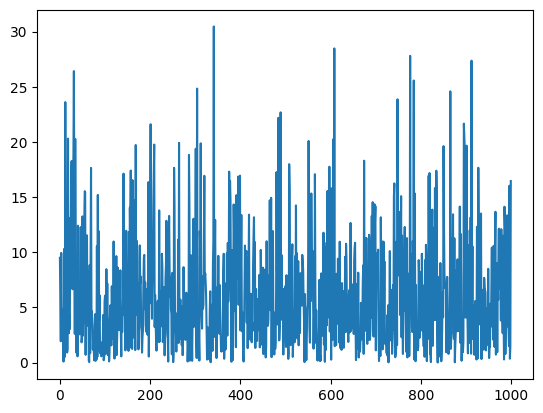

In [29]:

def test_score_diff(df: pd.DataFrame):
    diff_arr = []
    for row_idx in range(len(df)):
        scores = get_scores(df, row_idx)
        for score_idx, score in enumerate(scores):
            calc_score = get_rating(df, row_idx, score_idx, 8)
            diff = abs(score - calc_score)
            diff_arr.append(diff)
    
    return diff_arr

diff = test_score_diff(df)

print(f"DIFF: average: {np.average(diff)}, median: {np.median(diff)}")
plt.plot(np.arange(len(diff)), diff)